In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [68]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = df[date_col].dt.dayofyear
    return df 

### PJM Historical Load Forecasts
From https://dataminer2.pjm.com/feed/load_frcstd_hist

In [3]:
# PJM Load Forecasts
pjm_df = pd.concat(map(pd.read_csv, ['load_forecasts/pjm/2016.csv', 'load_forecasts/pjm/2017.csv','load_forecasts/pjm/2018.csv']))
pjm_df = pjm_df.drop(['evaluated_at_utc', 'evaluated_at_ept', 'forecast_hour_beginning_ept'], axis = 1)
pjm_df.columns = ['Date', 'area', 'PJM']

In [4]:
# RTO columns represent the load forecast for all of PJM
pjm_df = pjm_df.loc[pjm_df['area'] == 'RTO']

In [5]:
# There are multiple forecasts provided per hour so start by averaging them  
pjm_df = pjm_df.groupby( ['Date'] ).mean().reset_index()

In [6]:
pjm_df['Date'] = pd.to_datetime(pjm_df['Date'])
pjm_df = extract_date(pjm_df, 'Date') 

pjm_df = pjm_df.sort_values(by=['year', 'month', 'day', 'hour'])
pjm_df = pjm_df.set_index(['year', 'month', 'day', 'hour'])

pjm_df = pjm_df.drop(['Date'], axis = 1)

### Baseline: Compare PJM's Load Forecasts to Actual Generation

In [70]:
actual_gen = pd.read_csv('actual_gen.csv')

In [8]:
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])

actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [9]:
# Graph against PJM DF 
merged = actual_gen.merge(pjm_df, how='inner', left_index=True, right_index=True)

In [10]:
actual = merged[['mw']]
predicted = merged[['PJM']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
print("RMSE: " + str(((predicted.PJM - actual.mw) ** 2).mean() ** .5))

RMSE: 4888.143446172054


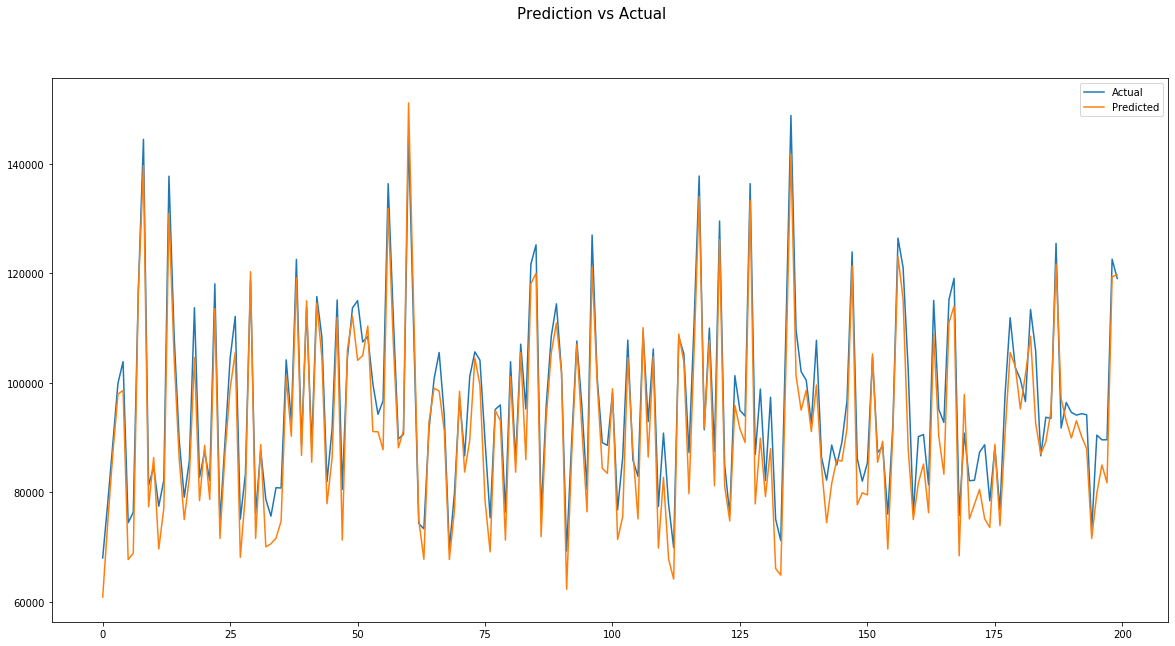

In [12]:
actual_100 = actual.head(200)
predicted_100 = predicted.head(200)

plt.figure(figsize=(20,10))
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['PJM'], label='Predicted')
plt.legend()

### Load Predictions

In [13]:
# Load predictions 
net_import_df = pd.read_csv('Predictions/import_export.csv', index_col = 0)
solar_pred = pd.read_csv('Predictions/solar_pred.csv', index_col = 0)
wind_pred = pd.read_csv('Predictions/wind_pred.csv', index_col = 0)

In [14]:
# Ensure column names are the same, set date time information as index 
net_import_df.columns = ['year', 'month', 'day', 'hour', 'net import']
solar_pred.columns = ['year', 'month', 'day', 'hour', 'solar']
wind_pred.columns = ['year', 'month', 'day', 'hour', 'wind']

net_import_df = net_import_df.set_index(['year', 'month', 'day', 'hour'])
solar_pred = solar_pred.set_index(['year', 'month', 'day', 'hour'])
wind_pred = wind_pred.set_index(['year', 'month', 'day', 'hour'])

In [15]:
# Combine predictions 
combined = net_import_df.merge(solar_pred, how='inner', left_index=True, right_index=True)
combined = combined.merge(wind_pred, how='inner', left_index=True, right_index=True)

In [16]:
combined = combined.reset_index()
combined = combined.sort_values(by=['year', 'month', 'day', 'hour'])
combined =combined.set_index(['year', 'month', 'day', 'hour'])

### Adjust Demand Forecasts

##### Demand Plus Net Imports and Solar / Wind Generation

In [30]:
fossil_gen = combined.merge(pjm_df, how='inner', left_index=True, right_index=True)

In [31]:
# Add net import with PJM 
fossil_gen['fossil gen'] = fossil_gen['PJM'] + fossil_gen['net import']

# Subtract solar and wind 
fossil_gen['fossil gen'] = fossil_gen['fossil gen'] - fossil_gen['solar'] - fossil_gen['wind']

In [32]:
with_import_renewables =  fossil_gen[['fossil gen']]

##### Demand Plus Net Imports 

In [33]:
# Add net import with PJM 
fossil_gen['with net import'] = fossil_gen['PJM'] + fossil_gen['net import']

In [34]:
demand_with_import =  fossil_gen[['with net import']]

##### Demand Plus Solar / Wind Generation

In [35]:
# Subtract solar and wind 
fossil_gen['with renewable'] = fossil_gen['PJM'] - fossil_gen['solar'] - fossil_gen['wind']

In [36]:
demand_less_renewables =  fossil_gen[['with renewable']]

### Compare Forecasted Result with Generation

In [38]:
actual_gen = pd.read_csv('actual_gen.csv')

In [39]:
actual_gen = actual_gen.loc[~actual_gen['fuel_type'].isin(['Wind', 'Solar'])]

In [40]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])


In [41]:
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

##### Compare with Generation Including Net Imports and Solar and Wind

In [42]:
merged = actual_gen.merge(with_import_renewables, how='inner', left_index=True, right_index=True)

actual = merged[['mw']]
predicted = merged[['fossil gen']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

actual_100 = actual.head(200)
predicted_100 = predicted.head(200)

In [43]:
print("RMSE: " + str(((predicted['fossil gen'] - actual.mw) ** 2).mean() ** .5))

RMSE: 12601.144242470016


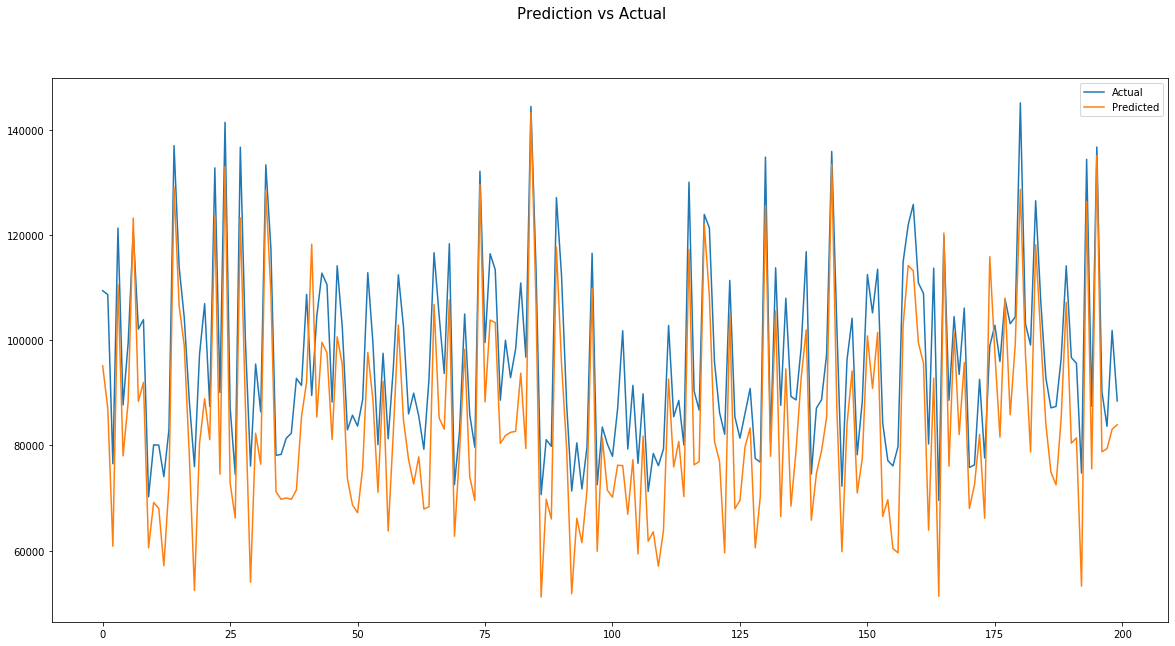

In [44]:
plt.figure(figsize=(20,10))
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['fossil gen'], label='Predicted')
plt.legend()

##### Compare with Generation Including Solar and Wind

In [45]:
merged = actual_gen.merge(demand_less_renewables, how='inner', left_index=True, right_index=True)

actual = merged[['mw']]
predicted = merged[['with renewable']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

actual_100 = actual.head(200)
predicted_100 = predicted.head(200)

In [46]:
print("RMSE: " + str(((predicted['with renewable'] - actual.mw) ** 2).mean() ** .5))

RMSE: 5317.788121875227


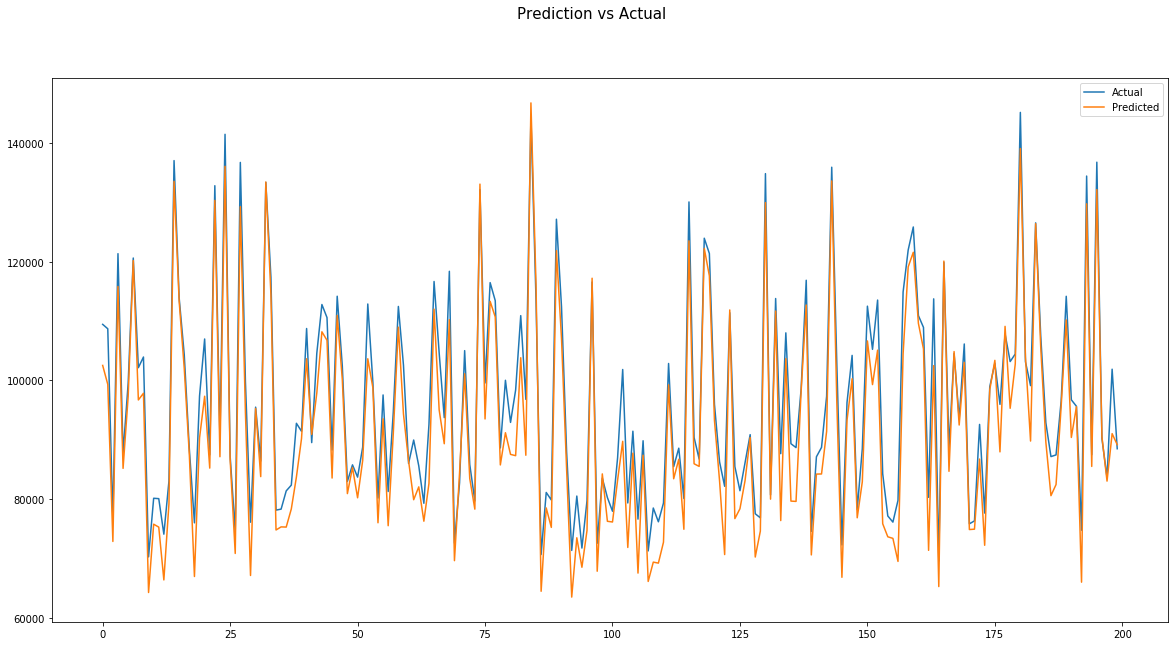

In [47]:
plt.figure(figsize=(20,10))
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['with renewable'], label='Predicted')
plt.legend()

##### Compare with Generation Including Net Imports

In [48]:
merged = actual_gen.merge(demand_with_import, how='inner', left_index=True, right_index=True)

actual = merged[['mw']]
predicted = merged[['with net import']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

actual_100 = actual.head(200)
predicted_100 = predicted.head(200)

In [49]:
print("RMSE: " + str(((predicted['with net import'] - actual.mw) ** 2).mean() ** .5))

RMSE: 10644.648975051565


### Compare to Fossil Generation (Coal, Gas, Multiple Fuels, Oil)

In [50]:
actual_gen = pd.read_csv('actual_gen.csv')

In [51]:
fossil_fuel_type = ['Coal', 'Gas', 'Multiple Fuels', 'Oil']
actual_gen = actual_gen.loc[actual_gen['fuel_type'].isin(fossil_fuel_type)]

In [52]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])


In [53]:
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [55]:
merged = actual_gen.merge(fossil_gen, how='inner', left_index=True, right_index=True)

actual = merged[['mw']]
predicted = merged[['fossil gen']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

actual_100 = actual.head(100)
predicted_100 = predicted.head(100)

/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [56]:
print("RMSE: " + str(((predicted['fossil gen'] - actual.mw) ** 2).mean() ** .5))

RMSE: 26043.995770542206


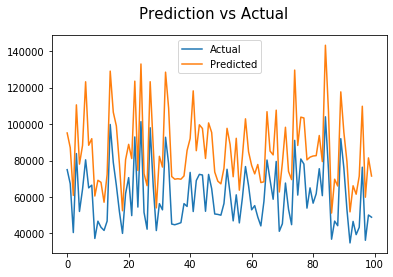

In [57]:
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['fossil gen'], label='Predicted')
plt.legend()

### Compare Solar / Wind Predictions with Actual
Sanity check to see if there's a bug in what I'm doing

#### Let's start with solar

In [58]:
actual_gen = pd.read_csv('actual_gen.csv')
actual_gen = actual_gen.loc[actual_gen['fuel_type'].isin(['Solar'])]

In [59]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [60]:
combined = actual_gen.merge(solar_pred, how='inner', left_index=True, right_index=True)

In [61]:
actual = combined[['mw']]
predicted = combined[['solar']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

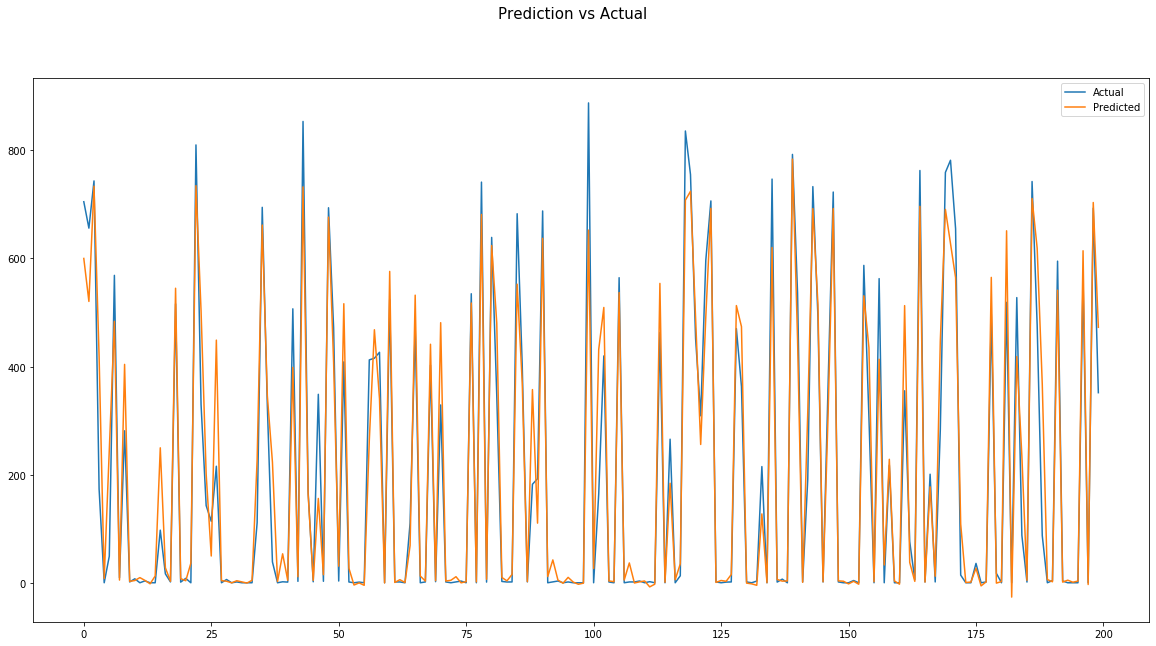

In [62]:
actual_100 = actual.head(200)
predicted_100 = predicted.head(200)
plt.figure(figsize=(20,10))
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['solar'], label='Predicted')
plt.legend()

#### Let's see what wind looks like 

In [63]:
actual_gen = pd.read_csv('actual_gen.csv')
actual_gen = actual_gen.loc[actual_gen['fuel_type'].isin(['Wind'])]

In [64]:
actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)
actual_gen = actual_gen.groupby( ['datetime_beginning_utc'] ).sum().reset_index()
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])
actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')
actual_gen = actual_gen.drop(['datetime_beginning_utc'], axis=1)
actual_gen = actual_gen.set_index(['year', 'month', 'day', 'hour'])

In [65]:
combined = actual_gen.merge(wind_pred, how='inner', left_index=True, right_index=True)

In [66]:
actual = combined[['mw']]
predicted = combined[['wind']]

actual['count'] = np.arange(len(actual))
predicted['count'] = np.arange(len(predicted))

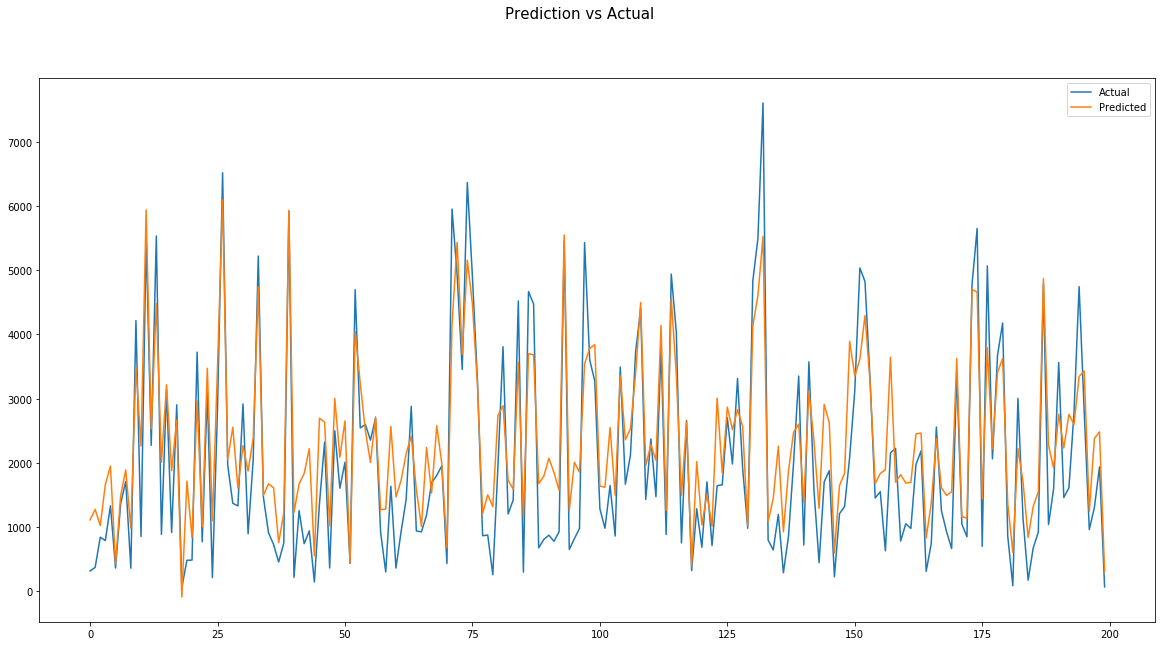

In [67]:
actual_100 = actual.head(200)
predicted_100 = predicted.head(200)
plt.figure(figsize=(20,10))
plt.suptitle('Prediction vs Actual', fontsize=15)
plt.plot(actual_100['count'], actual_100['mw'], label='Actual')
plt.plot(predicted_100['count'], predicted_100['wind'], label='Predicted')
plt.legend()

### Looking at Generation Data

In [76]:
actual_gen = pd.read_csv('actual_gen.csv')

In [73]:
actual_gen.fuel_type

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable
0,12/31/2018 5:00:00 AM,12/31/2018 12:00:00 AM,Coal,20227.0,0.24,False
1,12/31/2018 5:00:00 AM,12/31/2018 12:00:00 AM,Gas,23483.5,0.27,False
2,12/31/2018 5:00:00 AM,12/31/2018 12:00:00 AM,Hydro,2064.8,0.02,True
3,12/31/2018 5:00:00 AM,12/31/2018 12:00:00 AM,Multiple Fuels,3.2,0.00,False
4,12/31/2018 5:00:00 AM,12/31/2018 12:00:00 AM,Nuclear,34845.2,0.41,False
...,...,...,...,...,...,...
64431,5/1/2018 4:00:00 AM,5/1/2018 12:00:00 AM,Other,38.5,0.00,False
64432,5/1/2018 4:00:00 AM,5/1/2018 12:00:00 AM,Other Renewables,537.0,0.01,True
64433,5/1/2018 4:00:00 AM,5/1/2018 12:00:00 AM,Solar,17.4,0.00,True
64434,5/1/2018 4:00:00 AM,5/1/2018 12:00:00 AM,Storage,0.0,0.00,False


In [77]:
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])

actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_percentage_of_total', 'is_renewable'], axis=1)

In [79]:
pivot_df = actual_gen.pivot(index='datetime_beginning_utc', columns='fuel_type', values='mw')


In [89]:
pivot_df_segment = pivot_df.head(30)

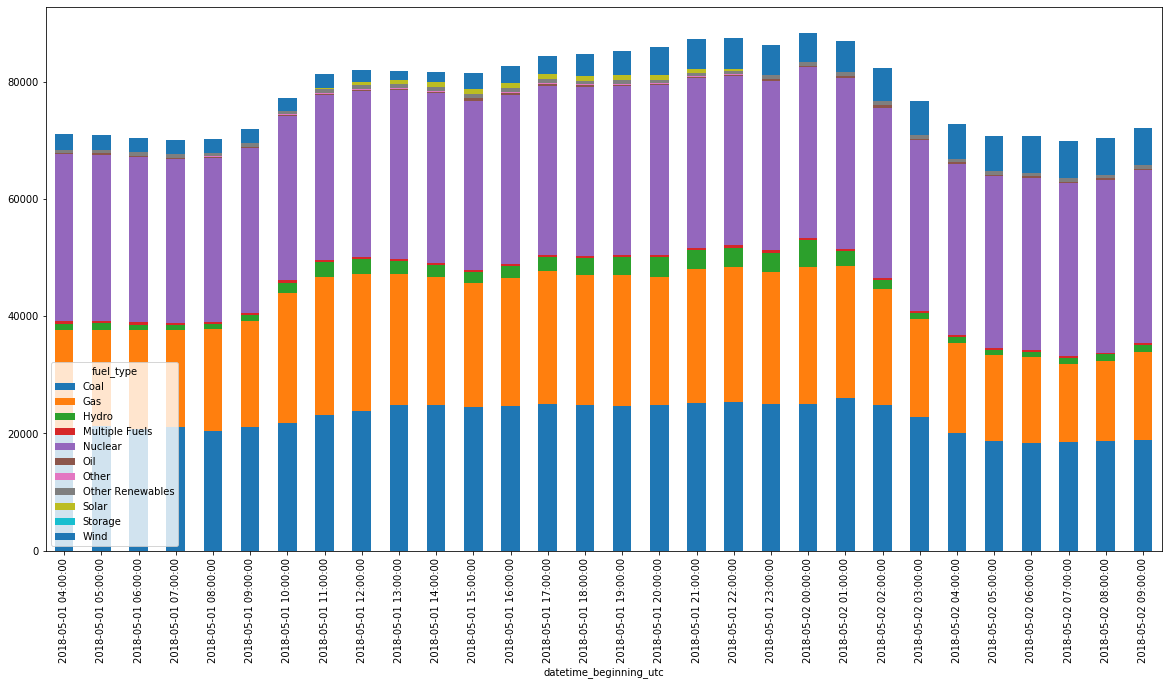

In [90]:
pivot_df_segment.plot.bar(stacked=True, figsize=(20,10))


### Nuclear Generation 

In [100]:
nuclear = actual_gen.loc[actual_gen['fuel_type'] == 'Nuclear']

In [102]:
nuclear = nuclear.drop(['fuel_type'], axis = 1)

In [129]:
nuclear_segment = nuclear.head(500)

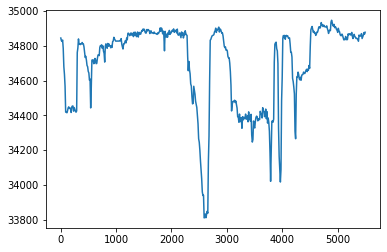

In [130]:
plt.plot(nuclear_segment['mw'])

### Hydro Generation

In [121]:
hydro = actual_gen.loc[actual_gen['fuel_type'] == 'Hydro']

In [122]:
hydro = hydro.drop(['fuel_type'], axis = 1)

In [127]:
hydro_segment = hydro.head(500)

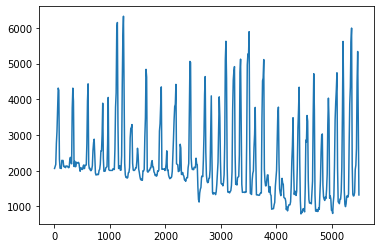

In [128]:
plt.plot(hydro_segment['mw'])